# Introducción

En el artículo *“Attributes of the permormance of central processing units: A relative performance prediction model”*, Ein-Dor, P., & Feldmesser, J. (1987) se propone un modelo de predicción lineal mediante regresión lineal para predecir el rendimiento relativo de la CPU en una amplia gama de máquinas de esa época. Se recopilaron datos de 209 CPU comercializadas entre 1981 y 1984. Las máquinas representaban un amplio espectro de prestaciones y fabricantes. El rendimiento relativo de las máquinas estudiadas oscilaba entre un mínimo de 6 y un máximo de 1150. Además de la información sobre el rendimiento relativo, los datos recogidos para cada CPU incluye el tiempo de ciclo de la máquina, el tamaño mínimo de la memoria, tamaño máximo de la memoria, número mínimo de canales, número máximo de canales y tamaño de la memoria cache.  <br>
Como resultado de la investigación anterior, se demostró que es posible modelar el rendimiento relativo de los sistemas informáticos con una precisión razonable a partir de los componentes del sistema. Además, es extensible a nuevas medidas de rendimiento que vayan surgiendo y, lo que es más importante, a nuevas arquitecturas. <br>
El objetivo del presente trabajo es replicar el experimento descrito en el artículo, corroborar sus resultados y obtener conclusiones.


# Desarrollo

### Importar librerías

In [21]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

### Data Info

In [22]:
data_info = requests.get('https://raw.githubusercontent.com/opcruz/datasets/main/machine.names')
print(data_info.content.decode('UTF-8'))

1. Title: Relative CPU Performance Data 

2. Source Information
   -- Creators: Phillip Ein-Dor and Jacob Feldmesser
     -- Ein-Dor: Faculty of Management; Tel Aviv University; Ramat-Aviv; 
        Tel Aviv, 69978; Israel
   -- Donor: David W. Aha (aha@ics.uci.edu) (714) 856-8779   
   -- Date: October, 1987
 
3. Past Usage:
    1. Ein-Dor and Feldmesser (CACM 4/87, pp 308-317)
       -- Results: 
          -- linear regression prediction of relative cpu performance
          -- Recorded 34% average deviation from actual values 
    2. Kibler,D. & Aha,D. (1988).  Instance-Based Prediction of
       Real-Valued Attributes.  In Proceedings of the CSCSI (Canadian
       AI) Conference.
       -- Results:
          -- instance-based prediction of relative cpu performance
          -- similar results; no transformations required
    - Predicted attribute: cpu relative performance (numeric)

4. Relevant Information:
   -- The estimated relative performance values were estimated by the autho

## Cargar Dataframe

In [23]:
df = pd.read_csv("https://raw.githubusercontent.com/opcruz/datasets/main/machine.data", sep=",",
                 names=["vendor", "model", "MCYT", "MMIN", "MMAX", "CACHE", "CHMIN", "CHMAX", "PRP", "ERP"])
df.head()

,vendor,model,MCYT,MMIN,MMAX,CACHE,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [24]:
df.shape

(209, 10)

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MCYT,209.0,203.822967,260.262926,17.0,50.0,110.0,225.0,1500.0
MMIN,209.0,2867.980861,3878.742758,64.0,768.0,2000.0,4000.0,32000.0
MMAX,209.0,11796.153110,11726.564377,64.0,4000.0,8000.0,16000.0,64000.0
CACHE,209.0,25.205742,40.628722,0.0,0.0,8.0,32.0,256.0
CHMIN,209.0,4.698565,6.816274,0.0,1.0,2.0,6.0,52.0
CHMAX,209.0,18.267943,25.997318,0.0,5.0,8.0,24.0,176.0
PRP,209.0,105.622010,160.830733,6.0,27.0,50.0,113.0,1150.0
ERP,209.0,99.330144,154.757102,15.0,28.0,45.0,101.0,1238.0


### Transformaciones

Se procede a aplicar las transformaciones que se muestran en el artículo

In [26]:
df2 = pd.DataFrame()

df2['CACH'] = df['CACHE'] / 10
df2['CHAVG'] = ((df['CHMIN'] + df['CHMAX']) / 2).astype('int') + 1
df2['SPEED'] = 1 / df['MCYT']
df2['CHCAP'] = df2['CHAVG'] * df2['SPEED'] * 10
df2['MAVG'] = (df['MMIN'] + df['MMAX']) / 2 * (10 ** -3)
df2['PRP_SR'] = df['PRP'] ** (1 / 2)

In [27]:
df2.head()

,CACH,CHAVG,SPEED,CHCAP,MAVG,PRP_SR
0,25.6,73,0.008000,5.840000,3.128,14.071247
1,3.2,21,0.034483,7.241379,20.000,16.401219
2,3.2,21,0.034483,7.241379,20.000,14.832397
3,3.2,21,0.034483,7.241379,20.000,13.114877
4,3.2,13,0.034483,4.482759,12.000,11.489125


#### Dividir en conjunto de pruebas y entrenamiento

In [28]:
from sklearn.model_selection import train_test_split

# Entrenamiento: 80%
# Pruebas: 20%
train_set, test_set = train_test_split(df2, test_size=0.20)
X_train = train_set[['MAVG', 'CACH', 'CHCAP']]
X_test = test_set[['MAVG', 'CACH', 'CHCAP']]
y_train = train_set[['PRP_SR']]
y_test = test_set[['PRP_SR']]

print("Datos originales:", df2.shape[0])
print("Datos para el entrenamiento:", X_train.shape[0])
print("Datos para prueba:", X_test.shape[0])

Datos originales: 209
Datos para el entrenamiento: 167
Datos para prueba: 42


El modelo lineal para la predicción del rendimiento relativo es el siguiente:
- *SQRPERF = A0 + A1(MAVG) + A2(CACH) + A3(CHCAP)*

### Entrenar el modelo

Se utilizará el modelo de regresión lineal de la librería *statsmodels*, usando el método de cuadrados mínimos

In [29]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 PRP_SR   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     641.5
Date:                Sat, 25 Mar 2023   Prob (F-statistic):           5.43e-90
Time:                        08:23:31   Log-Likelihood:                -312.02
No. Observations:                 167   AIC:                             632.0
Df Residuals:                     163   BIC:                             644.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2263      0.176     23.989      0.0

- Tomando en cuenta el alto valor que tiene el coeficiente de determinación (R-squared = 0.922) podemos afirmar que el modelo explica la mayor parte de la variación de los datos observados.
- El estadístico F (F = 641.5 > 1) provee evidencia convincente de que al menos una de las variables es útil para predecir la respuesta (Prob F-statistic = 5.43e-90 < 0.05)
- Si observamos los valores de probabilidad (p-values P>|t|) usando el estadístico t de cada variable, podemos apreciar que todos tienen un valor menor de 0.05, evidenciando que cada variable tiene una fuerte relación y son determinantes en el resultado final, por lo que no debe descartarse ninguna.

### Predecir valores de prueba y obtener métricas

In [30]:
from sklearn import metrics

X_test = sm.add_constant(X_test)
predictions = model.predict(X_test)

print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, predictions))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, predictions))

Mean Absolute Error: 1.3949994686756686
Mean Squared Error: 2.795079184648425
Root Mean Squared Error: 1.6718490316557966
Coefficient of determination: 0.87


- Se vuelve a evidenciar un alto valor del coeficiente de determinación usando ahora los datos de prueba, reafirmando que el modelo explica la variación de los datos.
- Se puede apreciar también unos valores de errores relativamente bajos confirmando la eficacia del modelo.

### Comparación con los datos del artículo

In [31]:
df2['ARTICLE_ERP_SR'] = df['ERP'] ** (1 / 2)

X = df2[['MAVG', 'CACH', 'CHCAP']]
X = sm.add_constant(X)

df2['MY_ERP_SR'] = model.predict(X)
df2.head()

,CACH,CHAVG,SPEED,CHCAP,MAVG,PRP_SR,ARTICLE_ERP_SR,MY_ERP_SR
0,25.6,73,0.008000,5.840000,3.128,14.071247,14.106736,16.021888
1,3.2,21,0.034483,7.241379,20.000,16.401219,15.905974,15.634867
2,3.2,21,0.034483,7.241379,20.000,14.832397,15.905974,15.634867
3,3.2,21,0.034483,7.241379,20.000,13.114877,15.905974,15.634867
4,3.2,13,0.034483,4.482759,12.000,11.489125,11.489125,11.545340


In [47]:
rss_article = ((df2['ARTICLE_ERP_SR'] - df2['PRP_SR']) ** 2).sum()
rss_calculated = ((df2['MY_ERP_SR'] - df2['PRP_SR']) ** 2).sum()

rse_article = math.sqrt(rss_article / (len(df2) - 2))
rse_calculated = math.sqrt(rss_calculated / (len(df2) - 2))

print("\t\t\t\tArtículo\tCalculado")
print("Interception\t\t\t3.78\t\t" + str(round(model.params[0], 3)))
print("MAVG\t\t\t\t0.49\t\t" + str(round(model.params[1], 3)))
print("CACH\t\t\t\t0.3\t\t" + str(round(model.params[2], 3)))
print("CHCAP\t\t\t\t0.19\t\t" + str(round(model.params[3], 3)))
print("RSS\t\t\t\t" + str(round(rss_article, 3)) + "\t\t" + str(round(rss_calculated, 3)))
print("RSE\t\t\t\t" + str(round(rse_article, 3)) + "\t\t" + str(round(rse_calculated, 3)))

				Artículo	Calculado
Interception			3.78		4.226
MAVG				0.49		0.388
CACH				0.3		0.332
CHCAP				0.19		0.359
RSS				568.379		527.67
RSE				1.657		1.597


Los valores de los coeficientes obtenidos son muy similares con los que muestra el artículo. Sin embargo, nuestro modelo entrenado arroja un valor de RSS (suma residual de cuadrados) menor, ajustandosé mejor a los datos. Este valor de RSS mide la cantidad de variabilidad después de llevar a cabo la regresión.

### Graficar regresión lineal 3D

El plano de regresión se genera utilizando la ecuación de la regresión lineal con uno de los predictores fijos y los otros dos variando en el rango de los datos.

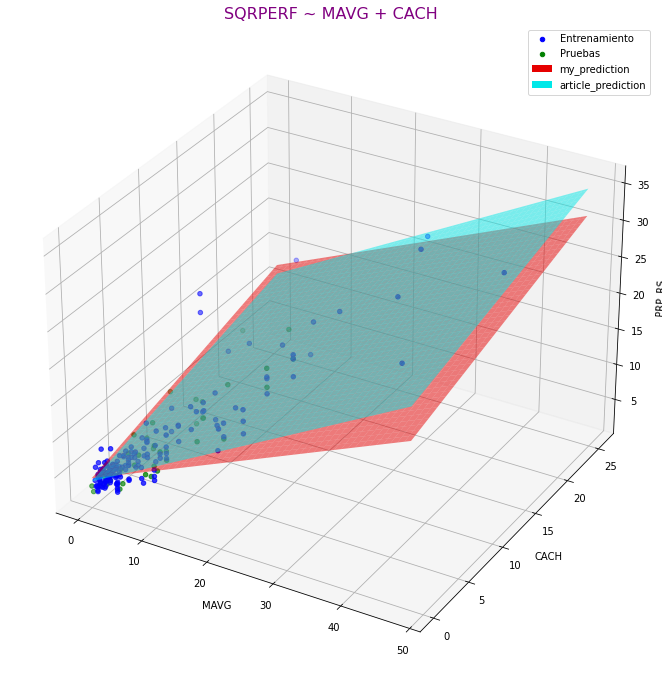

In [33]:
import matplotlib.pyplot as plt

# Graficar la regresión lineal en 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection="3d")
ax.set_position([0, 0, 0.95, 1])

ax.scatter(train_set['MAVG'], train_set['CACH'], train_set['PRP_SR'], c='blue', marker='o', label="Entrenamiento")
ax.scatter(test_set['MAVG'], test_set['CACH'], test_set['PRP_SR'], c='green', marker='o', label="Pruebas")

ax.set_xlabel('MAVG')
ax.set_ylabel('CACH')
ax.set_zlabel('PRP_RS')

xx1, xx2 = np.meshgrid(np.arange(df2['MAVG'].min(), df2['MAVG'].max(), 0.1),
                       np.arange(df2['CACH'].min(), df2['CACH'].max(), 0.1))

yy_calculated = model.params[1] * xx1 + model.params[2] * xx2 + model.params[0]

surf = ax.plot_surface(xx1, xx2, yy_calculated, alpha=0.5, color='red', label="my_prediction")
surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

yy_article = 0.49 * xx1 + 0.3 * xx2 + 3.78
surf = ax.plot_surface(xx1, xx2, yy_article, alpha=0.5, color='cyan', label="article_prediction")

surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

plt.legend()
plt.title("SQRPERF ~ MAVG + CACH", size=16, color="purple")
plt.show()

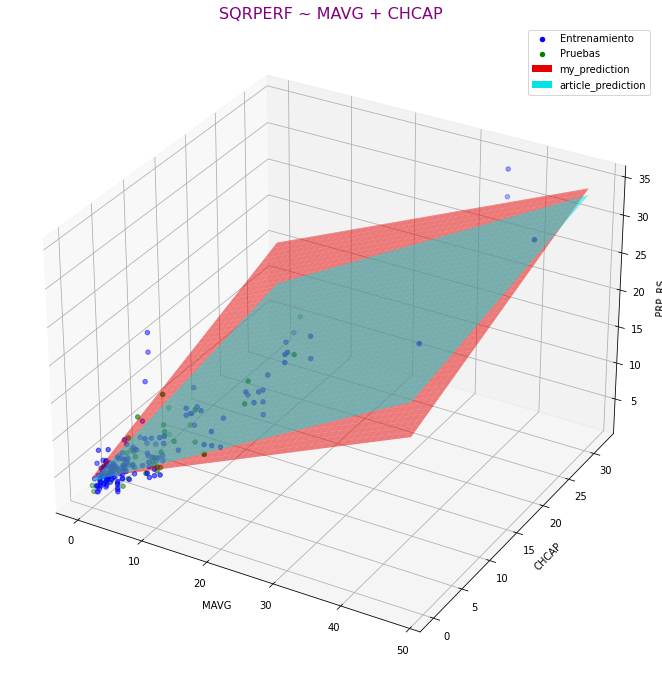

In [34]:
import matplotlib.pyplot as plt

# Graficar la regresión lineal en 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection="3d")
ax.set_position([0, 0, 0.95, 1])

ax.scatter(train_set['MAVG'], train_set['CHCAP'], train_set['PRP_SR'], c='blue', marker='o', label="Entrenamiento")
ax.scatter(test_set['MAVG'], test_set['CHCAP'], test_set['PRP_SR'], c='green', marker='o', label="Pruebas")

ax.set_xlabel('MAVG')
ax.set_ylabel('CHCAP')
ax.set_zlabel('PRP_RS')

xx1, xx2 = np.meshgrid(np.arange(df2['MAVG'].min(), df2['MAVG'].max(), 0.1),
                       np.arange(df2['CHCAP'].min(), df2['CHCAP'].max(), 0.1))

yy_calculated = model.params[1] * xx1 + model.params[3] * xx2 + model.params[0]

surf = ax.plot_surface(xx1, xx2, yy_calculated, alpha=0.5, color='red', label="my_prediction")
surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

yy_article = 0.49 * xx1 + 0.19 * xx2 + 3.78
surf = ax.plot_surface(xx1, xx2, yy_article, alpha=0.5, color='cyan', label="article_prediction")
surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

plt.legend()
plt.title("SQRPERF ~ MAVG + CHCAP", size=16, color="purple")
plt.show()

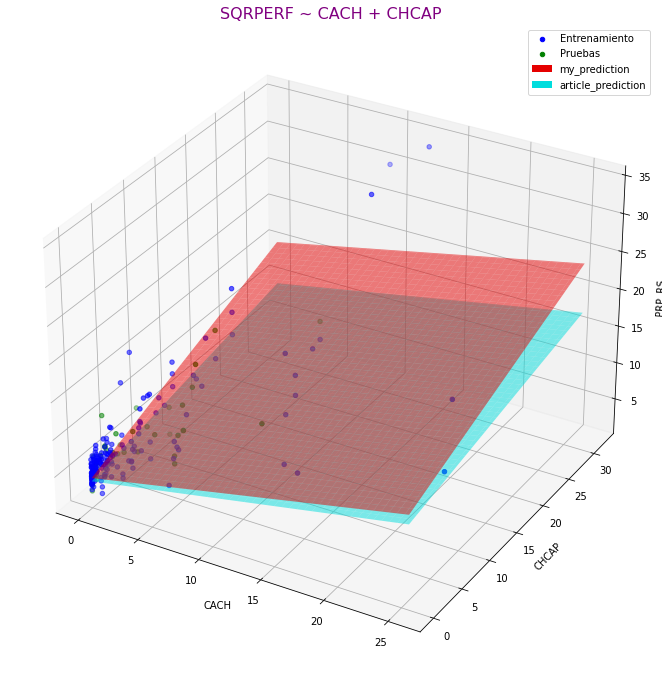

In [35]:
import matplotlib.pyplot as plt

# Graficar la regresión lineal en 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection="3d")
ax.set_position([0, 0, 0.95, 1])

ax.scatter(train_set['CACH'], train_set['CHCAP'], train_set['PRP_SR'], c='blue', marker='o', label="Entrenamiento")
ax.scatter(test_set['CACH'], test_set['CHCAP'], test_set['PRP_SR'], c='green', marker='o', label="Pruebas")
ax.set_xlabel('CACH')
ax.set_ylabel('CHCAP')
ax.set_zlabel('PRP_RS')

xx1, xx2 = np.meshgrid(np.arange(df2['CACH'].min(), df2['CACH'].max(), 0.1),
                       np.arange(df2['CHCAP'].min(), df2['CHCAP'].max(), 0.1))

yy_calculated = model.params[2] * xx1 + model.params[3] * xx2 + model.params[0]

surf = ax.plot_surface(xx1, xx2, yy_calculated, alpha=0.5, color='red', label="my_prediction")
surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

yy_article = 0.3 * xx1 + 0.19 * xx2 + 3.78
surf = ax.plot_surface(xx1, xx2, yy_article, alpha=0.5, color='cyan', label="article_prediction")

surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

plt.legend()
plt.title("SQRPERF ~ CACH + CHCAP", size=16, color="purple")
plt.show()

- Como podemos apreciar en las gráficas ambos modelos se ajustan bastante bien a los datos, evidenciando su precisión.
- Se puede ver que la tendencia general de los datos es a incrementar a medida que aumente el valor de las variables independientes, reflejando la correlación que existe entre las mismas.

## Regresión KNN

### Definición de funciones

In [36]:
def euclidian_distance(instance1, instance2, n_features):
    dist = 0
    for x in range(n_features):
        dist += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(dist)


# obtiene los K vecinos más cercanos
def get_neighbors(training_set, test_instance, k):
    distances = []
    for training_instance in training_set:
        dist = euclidian_distance(test_instance, training_instance, len(training_instance) - 1)
        distances.append((dist, training_instance))
    distances.sort(key=lambda x: x[0])
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][1])
    return neighbors


def predict_value(neighbors):
    return sum([neighbor[-1] for neighbor in neighbors]) / len(neighbors)


def knn_regressor_predict(training_set, test_set, k):
    predictions = []
    for instance in test_set:
        neighbors = get_neighbors(training_set, instance, k)
        result = predict_value(neighbors)
        predictions.append(result)
        print('> predicted=' + str(result) + ', actual=' + str(instance[-1]))
    return predictions


Entrenando el modelo de regresión KNN con k = 15. Usando los conjuntos de entrenamiento y test definidos con anterioridad

In [37]:
train_set = train_set[["MAVG", "CACH", "CHCAP", "PRP_SR"]]
test_set = test_set[["MAVG", "CACH", "CHCAP", "PRP_SR"]]

predictions = knn_regressor_predict(train_set.values, test_set.values, k=15)


> predicted=15.456799421051064, actual=16.64331697709324
> predicted=8.056335355480298, actual=6.708203932499369
> predicted=7.061756349665611, actual=10.246950765959598
> predicted=5.731303120316441, actual=5.196152422706632
> predicted=4.6579206095572925, actual=4.0
> predicted=10.996511133347871, actual=11.661903789690601
> predicted=5.647775256883109, actual=4.0
> predicted=5.5344431284576965, actual=4.242640687119285
> predicted=7.406240522295056, actual=8.366600265340756
> predicted=7.7031700562408965, actual=7.0710678118654755
> predicted=8.011867437694224, actual=10.770329614269007
> predicted=6.167278391029837, actual=4.898979485566356
> predicted=7.907228498074986, actual=6.164414002968976
> predicted=5.399915663782168, actual=4.123105625617661
> predicted=10.066792879086982, actual=12.0
> predicted=12.067096647006313, actual=16.09347693943108
> predicted=4.4692439039048315, actual=3.1622776601683795
> predicted=8.13297402820428, actual=11.489125293076057
> predicted=8.499048

### Métricas

In [38]:
y_test = test_set['PRP_SR'].values

print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, predictions))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, predictions))

Mean Absolute Error: 1.540492698345635
Mean Squared Error: 3.7047035734354625
Root Mean Squared Error: 1.9247606535451265
Coefficient of determination: 0.82


Se puede evidenciar un buen valor del coeficiente de determinación con los datos de pruebas al igual que el modelo anterior de regresión lineal. Sin embargo el modelo de regresión lineal tiene menor error y mejor coeficiente de determinación.

Entrenando ahora modelo de regresión KNN con k = 3. Modelo más flexible

In [51]:
predictions = knn_regressor_predict(train_set.values, test_set.values, k=3)


> predicted=17.212013444472806, actual=16.64331697709324
> predicted=6.961375699871424, actual=6.708203932499369
> predicted=7.356647910259372, actual=10.246950765959598
> predicted=6.3837231493367135, actual=5.196152422706632
> predicted=4.201850425154663, actual=4.0
> predicted=11.415654317884943, actual=11.661903789690601
> predicted=6.075101114981963, actual=4.0
> predicted=6.3837231493367135, actual=4.242640687119285
> predicted=8.448891632223928, actual=8.366600265340756
> predicted=6.535974344145152, actual=7.0710678118654755
> predicted=7.198036060895384, actual=10.770329614269007
> predicted=6.675577669777161, actual=4.898979485566356
> predicted=7.398637303036375, actual=6.164414002968976
> predicted=6.2260837433104, actual=4.123105625617661
> predicted=11.998101026041851, actual=12.0
> predicted=12.016774893839033, actual=16.09347693943108
> predicted=4.260242135164385, actual=3.1622776601683795
> predicted=6.772662618130002, actual=11.489125293076057
> predicted=8.595369400

In [52]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, predictions))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, predictions))

Mean Absolute Error: 1.4098212453703216
Mean Squared Error: 3.5908428247539828
Root Mean Squared Error: 1.8949519320431278
Coefficient of determination: 0.83


Vemos como con un menor valor de K el modelo se vuelve más flexible y se ajusta un poco mejor a los datos. Se obtiene un menor MSE (Error cuadrático medio) y un mayor R^2 (coeficiente de determinación), aunque no llega a ser significativo. Posiblemente el modelo se encuentre sobreajustado.

### Graficar regresión lineal y KNN 3D

Se fijará un predictor y los otros dos variarán en el rango de los datos.

In [48]:
x_plot, y_plot = np.meshgrid(np.linspace(df2['MAVG'].min(), df2['MAVG'].max(), 70),
                             np.linspace(df2['CACH'].min(), df2['CACH'].max(), 70))

z = np.column_stack((x_plot.ravel(), y_plot.ravel(), np.zeros(x_plot.ravel().shape)))
z_shaped = [np.append(value, -1) for value in z]
z_shaped = np.array(z_shaped)

z_plot = knn_regressor_predict(train_set.values, z_shaped, k=11)
z_plot = np.array(z_plot)
z_plot = z_plot.reshape(x_plot.shape)

yy_calculated = model.params[1] * xx1 + model.params[2] * xx2 + model.params[0]



> predicted=3.8531604260307817, actual=-1.0
> predicted=4.099769172520602, actual=-1.0
> predicted=4.598494479614569, actual=-1.0
> predicted=5.056320731022491, actual=-1.0
> predicted=5.828425153352615, actual=-1.0
> predicted=4.77323840259183, actual=-1.0
> predicted=5.206880207412914, actual=-1.0
> predicted=5.37284264321526, actual=-1.0
> predicted=6.798716512660686, actual=-1.0
> predicted=7.027867726066953, actual=-1.0
> predicted=7.073566992788636, actual=-1.0
> predicted=7.36946344192747, actual=-1.0
> predicted=7.639573327435944, actual=-1.0
> predicted=7.80986460908446, actual=-1.0
> predicted=7.80986460908446, actual=-1.0
> predicted=8.01655719958407, actual=-1.0
> predicted=8.01655719958407, actual=-1.0
> predicted=8.265784491688342, actual=-1.0
> predicted=8.987735801092713, actual=-1.0
> predicted=10.041741052827735, actual=-1.0
> predicted=10.753475858128667, actual=-1.0
> predicted=11.197446096460858, actual=-1.0
> predicted=12.207120083713335, actual=-1.0
> predicted=1

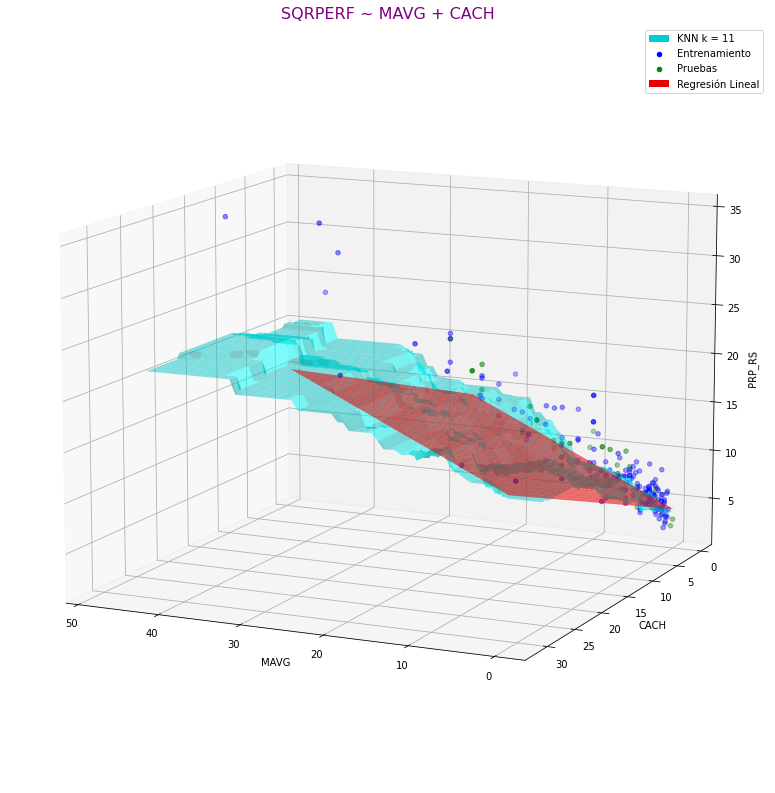

In [50]:
fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_plot, y_plot, z_plot, color='cyan', alpha=0.5, label="KNN k = 11")
surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

ax.scatter(train_set['MAVG'], train_set['CACH'], train_set['PRP_SR'], c='blue', marker='o', label="Entrenamiento")
ax.scatter(test_set['MAVG'], test_set['CACH'], test_set['PRP_SR'], c='green', marker='o', label="Pruebas")

surf = ax.plot_surface(xx1, xx2, yy_calculated, alpha=0.6, color='red', label="Regresión Lineal")
surf._facecolors2d = surf._facecolors
surf._edgecolors2d = surf._edgecolors

ax.view_init(elev=12, azim=115)

ax.set_xlabel('MAVG')
ax.set_ylabel('CACH')
ax.set_zlabel('PRP_RS')
plt.title("SQRPERF ~ MAVG + CACH", size=16, color="purple")
plt.legend()
plt.show()

- Ambos modelos tratan de ajustarse a los datos, evidenciando su precisión. Hay que tener en consideración que como se fijó un predictor que se utilizó en el entrenamiento el modelo no muestra un ajuste óptimo en la gráfica.
- Se puede ver que la tendencia general de los datos es a incrementar a medida que aumente el valor de las variables independientes, reflejando la correlación que existe entre las mismas.

## Comparación de los modelos

Los modelos evidencian buenos resultados de manera general. Si hacemos un ranking con los resultados obtenidos quedaría de la siguiente manera:
 1. Regresión lineal
 2. KNN k = 15 más restrictivo
 3. KNN k = 3 más flexible
 
 
- El modelo de regresión lineal además de obtener los mejores resultados (mayor valor de R^2 y menor MSE) y explicar mejor la variación de los datos, tiene como ventaja sobre el modelo de KNN que permite extrapolar y predecir valores fuera del rango de datos que se tiene con una precisión mayor.
- A pesar de que el modelo de regresión KNN con k = 3 obtuvo mejores valores de métricas que el que se obtuvo con k = 15, no llega a considerarse significativo para sacrificar interpretabilidad y aumentar la flexibilidad.
- Es importante tener en cuenta que hay otras métricas y técnicas que se pueden utilizar para comparar modelos de regresión y que la selección de la mejor métrica depende del objetivo específico del análisis y las características de los datos.

### Conclusiones

- Con la replicación del experimento siguiendo los pasos que se describieron en el artículo, se logró demostrar que es posible modelar el rendimiento relativo de los sistemas informáticos con una precisión razonable a partir de los componentes del sistema.
- Los tres predictores generados producto de la transformación de la información de los componentes del sistema son determinantes en la predicción del rendimiento relativo.
- El modelo de regresión lineal explica la mayor parte de la variación de los datos observados cuando se aplica a toda la gama de máquinas de la época.
- Es extensible a nuevas medidas de rendimiento que fueran surgiendo.
